In [1]:
import sys
sys.path.append('../')

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from src.sample_tiles import *
import pandas as pd

from src.tilenet import make_tilenet
from src.resnet import ResNet18
import torch
from time import time
from torch.autograd import Variable
import random

import rasterio
from rasterio.plot import show

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Extract image

**Place a few images of low pollution season in '../data.nosync/planet-lab-images/low/', same for high.**


In [3]:
im_dir_path = '../data.nosync/planet-lab-images/'
tile_dir_path = '../data.nosync/planet-lab-tiles/'

im_dir_low = im_dir_path + 'low/'
im_dir_high = im_dir_path + 'high/'
tiles_dir_low = tile_dir_path + 'low/'
tiles_dir_high = tile_dir_path + 'high/'

low_high_dict = {im_dir_low: tiles_dir_low,
                 im_dir_high: tiles_dir_high}


In [4]:
for img_dir, tile_dir in low_high_dict.items():
    try:
        os.remove(os.path.join(tile_dir, '.DS_Store'))
    except:
        pass
    try:
        os.remove(os.path.join(img_dir, '.DS_Store'))
    except:
        pass

In [5]:
# look at a random inage from the im_dir_high
# if it picks .DS_Store, try again or remove that file

img_file = im_dir_high + random.sample(os.listdir(im_dir_high), 1)[0]

with rasterio.open(img_file) as src:
    profile = src.profile

In [6]:
profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9011, 'height': 4370, 'count': 4, 'crs': CRS.from_dict(init='epsg:32643'), 'transform': Affine(3.0, 0.0, 675789.0,
       0.0, -3.0, 3196353.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

Make a padding to get coodinates for the tiles

In [8]:
tile_radius = 50

img_data = load_img(img_file, val_type='uint16', bands_only=False)


img_padded = np.pad(img_data, pad_width=[(tile_radius, tile_radius),
                                             (tile_radius, tile_radius), 
                                             (0,0)],
                        mode='reflect')
img_shape = img_padded.shape

### Visualize a tile form that image

In [15]:
x, y = sample_anchor(img_shape, tile_radius)
tile = extract_tile(img_padded, x, y, tile_radius)
tile = tile[:-1,:-1] # see size_even


In [16]:
# need tile_size = 50 to feel into the CNN but can use a bigger one to visualize
tile_size=1000
tile_radius = tile_size // 2

x, y = sample_anchor(img_shape, tile_radius)
tile = extract_tile(img_padded, x, y, tile_radius)
tile = tile[:-1,:-1] # see size_even

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


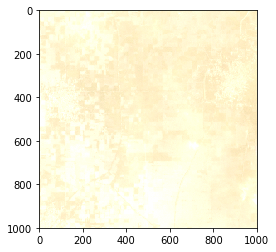

In [20]:
plt.imshow(tile[:,:,[0,1,2]] / 10000.0 )

Here you can play with the settings, still not sure which is the right one

# Sample tiles

Here we are going to sample a couple thousand tiles from low pollution days and a couple thousand from high polution.

The cell below will extract tiles_per_image tiles for each image present in img_dir directory.

In [21]:
tiles_per_image = 500
tile_size=50
tile_radius = tile_size // 2

for img_dir, tile_dir in low_high_dict.items():

    for image in os.listdir(img_dir):
        print('Saving tiles for ', image, ' in ', tile_dir)
        img = load_img(os.path.join(img_dir, image), val_type='uint16', bands_only=True)
        img_padded = np.pad(img, pad_width=[(tile_radius, tile_radius),
                                            (tile_radius, tile_radius), 
                                            (0,0)],
                            mode='reflect')
        img_shape = img_padded.shape

        for i in range(tiles_per_image):
            x, y = sample_anchor(img_shape, tile_radius)
            tile = extract_tile(img_padded, x, y, tile_radius)
            tile = tile[:-1,:-1] # see size_even
            tile = tile[:,:,[3,2,1,0]] / 10000.0
            np.save(os.path.join(tile_dir, 'planet_tile_' + image[4:15] + '_{}.npy'.format(i)), tile)
            i = i+1


Saving tiles for  20181122_050348_0f12.tif  in  ../data.nosync/planet-lab-tiles/low/
Saving tiles for  20180710_050010_1014.tif  in  ../data.nosync/planet-lab-tiles/high/


## Visualize some of the tiles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_57.npy


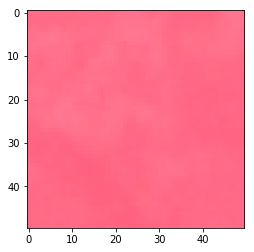

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_280.npy


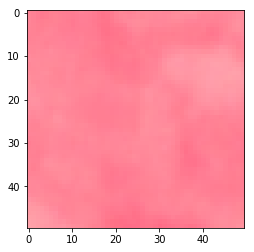

Tile planet_tile_1122_050348_116.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


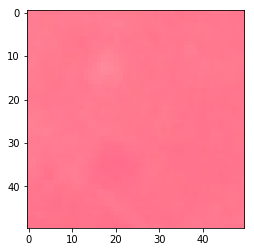

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_352.npy


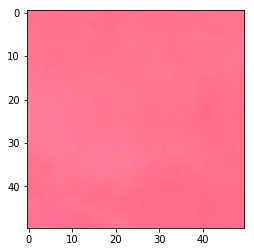

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_110.npy


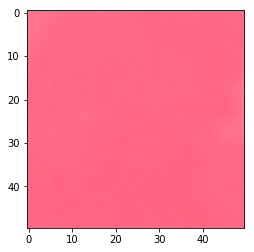

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_255.npy


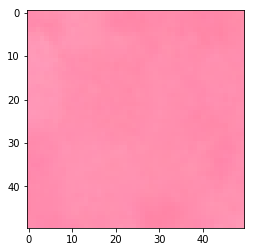

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_251.npy


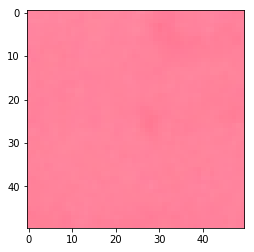

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_437.npy


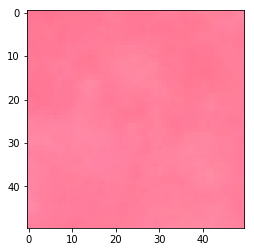

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_457.npy


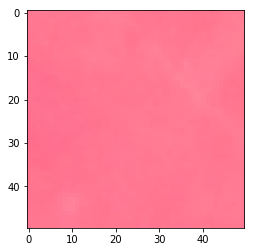

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_1122_050348_447.npy


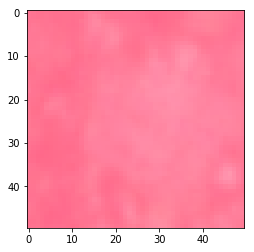

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_44.npy


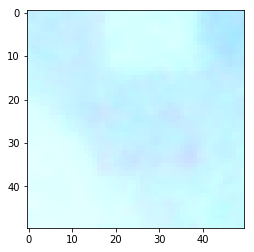

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_164.npy


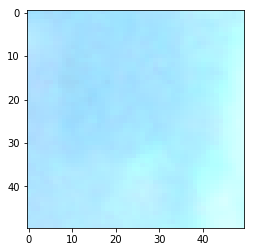

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_23.npy


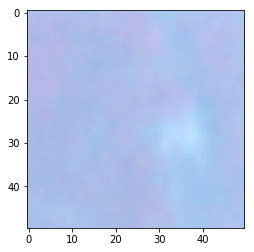

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_188.npy


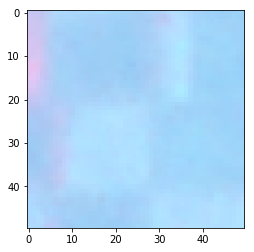

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_277.npy


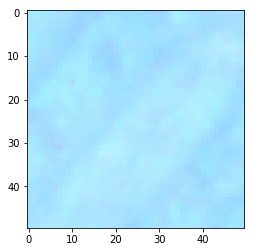

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_4.npy


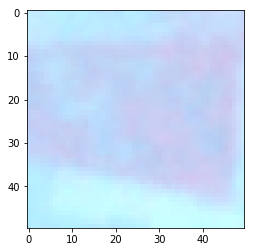

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_373.npy


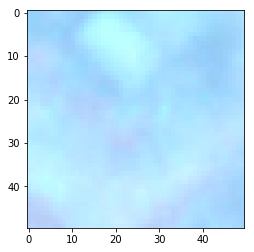

Tile planet_tile_0710_050010_289.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


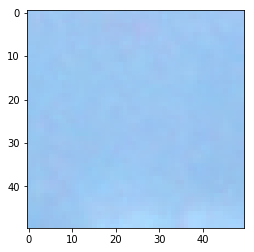

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_189.npy


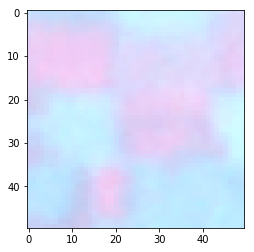

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tile planet_tile_0710_050010_374.npy


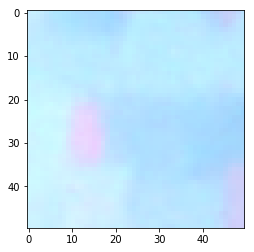

In [29]:
tile_dir = tiles_dir_low
plt.rcParams['figure.figsize'] = (4,4)
n_tile_plot = 10

for img_dir, tile_dir in low_high_dict.items():
    i = 0
    for filename in random.sample(os.listdir(tile_dir), n_tile_plot):
        tile = np.load(os.path.join(tile_dir, filename))
        print('Tile ' + filename)
        plt.imshow(tile[:,:,[0,1,2]])
        i +=1
        plt.show()

# Remove Black Tiles

Tiles that are sampled in the black area are all black, and have a close to zero mean for all their values. We remove them.

In [28]:
for img_dir, tile_dir in low_high_dict.items():
    filenames = os.listdir(tile_dir)
    before = len(filenames)
    for filename in filenames:
        tile = np.load(os.path.join(tile_dir, filename))
        if tile.mean() < 0.01:
            os.remove(os.path.join(tile_dir, filename))
    filenames = os.listdir(tile_dir)
    print('Removed ', before - len(os.listdir(tile_dir)), ' black tiles from ', tile_dir)

Removed  192  black tiles from  ../data.nosync/planet-lab-tiles/low/
Removed  174  black tiles from  ../data.nosync/planet-lab-tiles/high/


# Load Pre-trained Model

In [22]:
# Setting up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()
# tilenet = make_tilenet(in_channels=in_channels, z_dim=z_dim)
# Use old model for now
tilenet = ResNet18()
if cuda: tilenet.cuda()

In [25]:
# Load parameters
model_fn = '../models/naip_trained.ckpt'
checkpoint = torch.load(model_fn, map_location='cpu')
tilenet.load_state_dict(checkpoint)
tilenet.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

# Embbed Tiles

In [ ]:
# the features table for low and high PM25 samples

# instanciate
X_low = np.zeros((1, z_dim))
X_high = np.zeros((1, z_dim))
X_dict = {tile_dir_low: X_low,
          tile_dir_high: X_high}

# loop over all tiles and calculate embedding. It takes about 1 min for 500 tiles on my computer, so take it easy
for tile_dir, X in X_dict.items():
    print('Parsing ', tile_dir)
    n_tiles = len(os.listdir(tile_dir))
    X = np.zeros((n_tiles, z_dim))
    # Embed tiles
    t0 = time()
    i = 0
    for filename in os.listdir(tile_dir):
        while i < n_tiles:
            tile = np.load(os.path.join(tile_dir, filename))
            # Get first 4 NAIP channels (5th is CDL mask)
            tile = tile[:,:,:4]
            # Rearrange to PyTorch order
            tile = np.moveaxis(tile, -1, 0)
            tile = np.expand_dims(tile, axis=0)
            # Scale to [0, 1]
            tile = tile / 255
            # Embed tile
            tile = torch.from_numpy(tile).float()
            tile = Variable(tile)
            if cuda: tile = tile.cuda()
            z = tilenet.encode(tile)
            if cuda: z = z.cpu()
            z = z.data.numpy()
            X[i,:] = z
            i += 1
            if i % 100 == 0:
                print(i, ' / ', n_tiles)
        t1 = time()
    X_dict[tile_dir] = X
    print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
    print('Features table shape : ', X.shape)

# Machine Learning

## Concatenate Features Datatable and get labels


In [ ]:
df_high = pd.DataFrame(X_dict[tile_dir_high])
df_high['label'] = 1

df_low = pd.DataFrame(X_dict[tile_dir_high])
df_low['label'] = 0


features = pd.concat([df_high, df_low], axis = 0)
features.shape

In [ ]:
features = features.reset_index()
labels = features['label']
features = features.drop('label', axis = 1)

## Low VS High Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

This is a grid search that tries to find optimal hypoerparameters on different model. You can also do it more 'by-hand'

In [ ]:
test_size=0.30

random_state = 13
held_out_size = 0.3
n_splits = 3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
             features, 
             labels, 
             test_size=test_size,
             shuffle = True,
             random_state = random_state)
    
kfold = KFold(n_splits = 3,              
              random_state = random_state)

In [ ]:
binary_models = [LogisticRegression(solver = 'liblinear'),
                 DecisionTreeClassifier(),
                 KNeighborsClassifier(),
                 RandomForestClassifier(random_state = random_state, n_estimators = 33),
                 MLPClassifier(learning_rate='adaptive', learning_rate_init = 0.1, random_state = random_state),
                 MLPClassifier(learning_rate='adaptive', learning_rate_init = 0.1, random_state = random_state)]

parameterScope = [{'penalty' : ['l1', 'l2'], 'C' :  [000.1, 0.005, 0.01, 0.1]},
                  {'min_samples_leaf' : list(range(5, 100, 45))},
                  {'n_neighbors' : list(range(10, 100, 10))},
                  {'max_depth' : list(range(2, 10, 2)), 
                   'n_estimators' : range(20, 85, 30)}]

binary_names = ['Logistic Regression',
                'Decision Tree',
                'K-Nearest Neighbors',
                'Random Forest']

In [ ]:
fitted_binary_models = []
performance = pd.Series()
bestParam = pd.Series()


for model, parameters, name in zip(binary_models, parameterScope, binary_names):
    parameterEstimator = GridSearchCV(model, parameters, cv = kfold, refit = True, return_train_score=False)
    parameterEstimator.fit(X_train, y_train)
    performance[name] = parameterEstimator.best_score_
    bestParam[name] = parameterEstimator.best_params_
    print(name)
    print(performance[name])
    print(bestParam[name])
    fitted_binary_models.append(parameterEstimator.best_estimator_)

bestParam